In [30]:
import numpy as np
import pandas as pd
#读取数据集
airCompany = pd.read_csv('./Q1data/air_data.csv', encoding='gb18030')
print('原始数据的形状为：', airCompany.shape)
#去除两年票价收入都为空的数据（这些数据可能是有误）
price1 = airCompany['SUM_YR_1'].notnull()
price2 = airCompany['SUM_YR_2'].notnull()
priceEmpty = price1&price2
airData = airCompany.loc[priceEmpty,:]
print('删除异常数据后，数据的形状为：', airData.shape)
#选取特征构建模型（数据中无关紧要的信息不少，如会员卡号、工作城市等这些不是我们这次分析的重点）
#这里选取加入会员时间（需计算）、飞行总里程、平均飞行时间间隔、平均票价收入（没有给出，需要计算）
airDataPro = airData[['FFP_DATE','LOAD_TIME','SUM_YR_1','SUM_YR_2','SEG_KM_SUM','AVG_INTERVAL']]
#计算入会时间(单位：月)
MemberAge = pd.to_datetime(airDataPro['LOAD_TIME']) - pd.to_datetime(airDataPro['FFP_DATE'])
MemberAge = MemberAge.astype('str').str.split().str[0]
MemberAge = MemberAge.astype('int')/30
#计算平均票价收入
AVG_SUM_YR = (airDataPro['SUM_YR_1'] + airDataPro['SUM_YR_2']) / 2
#合并所选取的数据特征
airDataMerge = pd.concat([MemberAge, AVG_SUM_YR, airDataPro.iloc[:,4:]], axis = 1)
print('构建的数据分析模型特征的前5行为：\n', airDataMerge.head())
#对特征数据标准化
from sklearn.preprocessing import StandardScaler
airStandardData = StandardScaler().fit_transform(airDataMerge)
np.savez('./Q1data/airStandardData.npz',airStandardData)
print('标准化后的数据分析模型的4个特征为：\n',airStandardData[:5,:])

原始数据的形状为： (62988, 44)
删除异常数据后，数据的形状为： (62299, 44)
构建的数据分析模型特征的前5行为：
            0         1  SEG_KM_SUM  AVG_INTERVAL
0  90.200000  236874.0      580717      3.483254
1  86.566667  169458.5      293678      5.194245
2  87.166667  164300.0      283712      5.298507
3  68.233333  120925.0      281336     27.863636
4  60.533333  127631.0      309928      4.788079
标准化后的数据分析模型的4个特征为：
 [[ 1.4373877  30.12938103 26.79983172 -0.83270617]
 [ 1.30881545 21.3501806  13.146951   -0.81067985]
 [ 1.33004756 20.67841364 12.6729227  -0.80933762]
 [ 0.6600564  15.02989337 12.55990933 -0.51884706]
 [ 0.3875776  15.9031839  13.91987493 -0.81590858]]


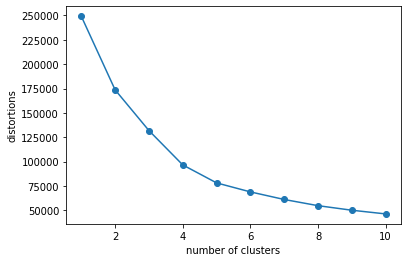

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#使用肘方法选取k值
d=[]
for i in range(1,11):    #k取值1~11，做kmeans聚类，看不同k值对应的簇内误差平方和
    km=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(airStandardData)
    d.append(km.inertia_)  #inertia簇内误差平方和
#肘处的K即为最佳K值,这里我选的是4
plt.plot(range(1,11),d,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortions')
plt.show()

In [32]:
#使用聚类算法对航空客户进行分群
from sklearn.cluster import KMeans
airStandardData = np.load('./Q1data/airStandardData.npz')['arr_0']
#聚类个数k自己选定，如果没有使用肘方法，这里可以多尝试几种情况，看看各分群的区分度明不明显，最后确定k的取值
k=4
kmeans = KMeans(n_clusters=k, random_state=200)
fitKmeans = kmeans.fit(airStandardData)
print("查看各客户群的聚类中心：")
kmeans.cluster_centers_

查看各客户群的聚类中心：


array([[-0.70249642, -0.23348758, -0.23436337, -0.19163667],
       [-0.18303559, -0.55396226, -0.60690825,  2.73870212],
       [ 0.47595878,  2.51142901,  2.53737546, -0.63527122],
       [ 1.11374889, -0.12305285, -0.11556951, -0.16835451]])

In [33]:
#统计各客户群的数目
r1 = pd.Series(kmeans.labels_).value_counts() #统计各个类别的数目
#找出聚类中心
r2 = pd.DataFrame(kmeans.cluster_centers_) 
r = pd.concat([r2, r1], axis = 1) 
r.columns = ['入会时长', '票价收入', '飞行里程', '时间间隔', '类别数目']
print(r)
#根据分析结果可以看出：
#第1类客户是那种比较晚加入会员，并且花费不多，乘机频率也相对较少。这属于一般客户
#第2类客户是较早加入会员，飞行里程很大、飞行频率不高且花费意愿不错，是优质客户
#第3类客户是很早加入会员，但现在乘机频率减少花费也有减少，建议回访搞清楚其中原因
#第4类客户飞行频率最高，但花费不多，可以尝试明确其需求，针对提供更多收费服务

入会时长      票价收入      飞行里程      时间间隔   类别数目
0 -0.702496 -0.233488 -0.234363 -0.191637  33080
1 -0.183036 -0.553962 -0.606908  2.738702   4685
2  0.475959  2.511429  2.537375 -0.635271   5064
3  1.113749 -0.123053 -0.115570 -0.168355  19470
